## Test SCT+scanpy pipeline

In this notebook I want to test SCT+scanpy pipeline. For 2 selected dataset, I am comparing clustering from SCT-Seurat workflow, clustering from scanpy-vanilla workflow and clustering from SCT+scanpy workflow: it uses Seurat to perform SCTransform and select highly-variable genes, then dumps that to disk, and these data are loaded into scanpy to perform pca and all downstream analysis.

**scanpy-vanilla** workflow is named **Vanilla**

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.io
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
sys.path.insert(0, "../lib/")

In [3]:
import sankey

In [4]:
import importlib

In [5]:
importlib.reload(sankey)

<module 'sankey' from '../lib/sankey.py'>

In [6]:
mpl.rcParams["figure.figsize"] = (6, 6)

In [7]:
def rename_genes(names):
    names = names.str.replace("^GRCh38_+", "")
    names = names.str.replace("^SARS-CoV-2i_", "SARS-CoV-2-")
    names = names.str.replace("SARS-CoV-2-antisense", "Antisense")
    return names

# Dataset SC96

## Vanilla scanpy

Most basic workflow, uses log-normalization strategy:
* filter out cells with less than 200 genes and genes with less than 5 cells
* log-normalize to 10k counts
* select 3k HVG
* scale
* pca
* knn with 15 pcs
* leiden with 0.5 resolution

In [8]:
sc96 = sc.read_10x_mtx(
    "../../data/02sctransform-test/SC96/",
    var_names="gene_symbols",
    make_unique=False
)
sc96.var_names_make_unique(join=".")
sc96.var_names = rename_genes(sc96.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
sc.pp.filter_cells(sc96, min_genes=200)
sc.pp.filter_genes(sc96, min_cells=5)
sc.pp.normalize_total(sc96, target_sum=1e4)
sc.pp.log1p(sc96)
sc96.raw = sc96
sc.pp.highly_variable_genes(sc96, n_top_genes=3000)
sc.pp.scale(sc96)
sc.tl.pca(sc96, svd_solver="arpack", use_highly_variable=True)

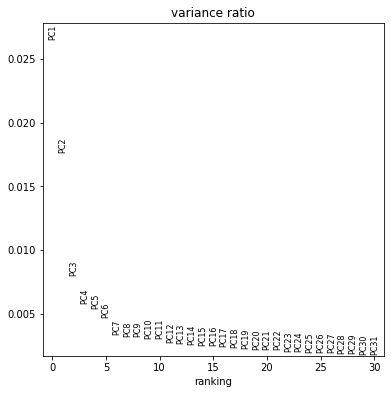

In [10]:
sc.pl.pca_variance_ratio(sc96)

In [11]:
sc.pp.neighbors(sc96, n_pcs=15)

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/.venv/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


In [12]:
sc.tl.leiden(sc96, resolution=0.5)

In [13]:
sc.tl.umap(sc96)

We're looking at macrophage heterogeneity with these genes

In [14]:
ax = sc.pl.umap(sc96, color=['leiden', 'FABP4', 'CCL2'], show=False, legend_loc="on data")
ax[0].figure.savefig("sc96-vanilla.pdf")

... storing 'feature_types' as categorical


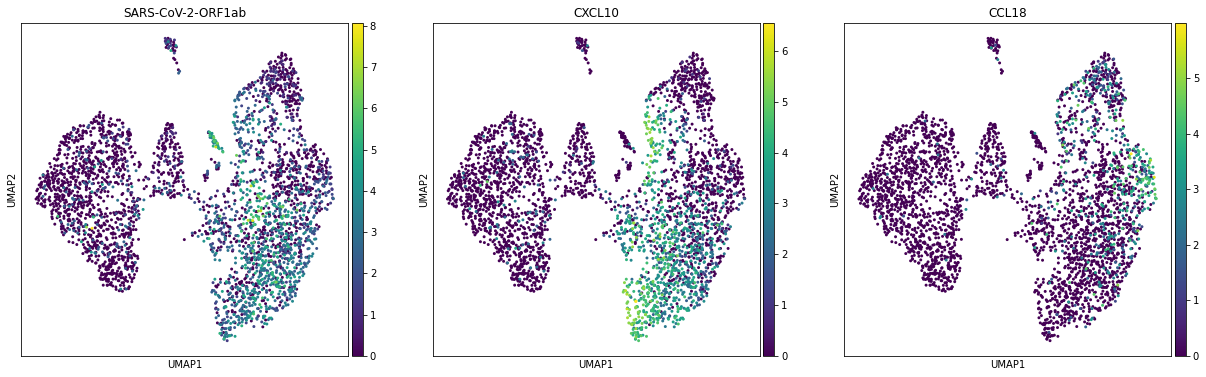

In [15]:
ax = sc.pl.umap(sc96, color=['SARS-CoV-2-ORF1ab', 'CXCL10', 'CCL18'], show=False)
ax[0].figure.savefig("sc96-vanilla2.pdf")

## SCT+scanpy

SCT+scanpy workflow, uses SCT normalization exported from Seurat:
* in Seurat, filter data with min_genes = 200, min_cells = 5
* in Seurat, run SCTransform with 3k for number of HVG
* in scanpy, load SCT log-counts and set them as raw dataset
* in scanpy, load SCT residuals for HVG, set them in X, and 0 for all other genes
* pca
* knn with 15 pcs
* leiden with 0.5 resolution

In [16]:
sc96_sct = sc.read_10x_mtx(
    "../../data/02sctransform-test/SC96/",
    var_names="gene_symbols",
    make_unique=False
)
sc96_sct.var_names_make_unique(join=".")
sc96_sct.var_names = rename_genes(sc96_sct.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [17]:
sc.pp.filter_cells(sc96_sct, min_genes=200)
sc.pp.filter_genes(sc96_sct, min_cells=5)

Loading SCT log-counts

In [18]:
counts = scipy.io.mmread("../../data/02sctransform-test/SC96-sct/log-counts.mtx")

In [19]:
sc96_sct.X = counts.tocsc().T
sc96_sct.raw = sc96_sct

Loading SCT residuals

In [20]:
scaled = pd.read_csv("../../data/02sctransform-test/SC96-sct/hvg-scaled.tsv", sep="\t")

In [21]:
scaled.index = scaled.index.str.replace("SARS-CoV-2i-", "SARS-CoV-2i_").str.replace("GRCh38------", "GRCh38______")
scaled.index = rename_genes(scaled.index)

In [22]:
missing_genes = sc96_sct.var_names[~sc96_sct.var_names.isin(scaled.index)]

Add 0 to residuals for non-HVG genes

In [23]:
zeros = np.zeros((sc96_sct.n_obs, missing_genes.size))

In [24]:
zeros = pd.DataFrame(zeros, index=sc96_sct.obs_names, columns=missing_genes)

In [25]:
sc96_sct.X = pd.concat([scaled.T, zeros], axis=1).loc[:, sc96_sct.var_names]

Manually set HVG flag

In [26]:
sc96_sct.var["highly_variable"] = False
sc96_sct.var.loc[sc96_sct.var_names.isin(scaled.index), "highly_variable"] = True

In [27]:
sc.tl.pca(sc96_sct, svd_solver="arpack", use_highly_variable=True)

In [28]:
sc.pl.pca_variance_ratio(sc96_sct)

In [29]:
sc.pp.neighbors(sc96_sct, n_pcs=15)

In [30]:
sc.tl.leiden(sc96_sct, resolution=0.5)

In [31]:
sc.tl.umap(sc96_sct)

In [32]:
ax = sc.pl.umap(sc96_sct, color=['leiden', 'FABP4', 'CCL2'], show=False, legend_loc="on data")
ax[0].figure.savefig("sc96-sct.pdf")

... storing 'feature_types' as categorical


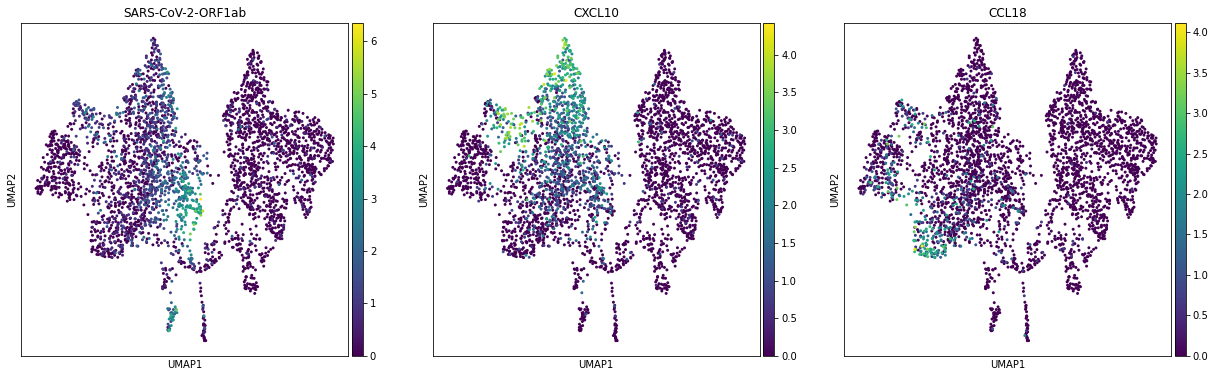

In [33]:
ax = sc.pl.umap(sc96_sct, color=['SARS-CoV-2-ORF1ab', 'CXCL10', 'CCL18'], show=False)
ax[0].figure.savefig("sc96-sct2.pdf")

## SCT-seurat

SCT-Seurat workflow, uses SCT normalization in Seurat:
* SCTransfrom with default parameters (3k features)
* pca
* FindNeighbors with 15 pcs
* FindClusters with 0.5 resolution

In [34]:
sc96_seurat = pd.read_csv("../../data/02sctransform-test/SC96-metadata.csv", index_col=0)

In [35]:
sc96_seurat

orig.ident  nCount_RNA  nFeature_RNA  percent.mt  \
SC96_AAACCTGAGAAACCGC-1       SC96        1076           648    2.973978   
SC96_AAACCTGAGCGTTTAC-1       SC96         836           588    1.555024   
SC96_AAACCTGCAACTGCGC-1       SC96        2174          1035    3.035879   
SC96_AAACCTGCATTGAGCT-1       SC96        1251           701    1.758593   
SC96_AAACCTGTCGGATGTT-1       SC96        4220          1320    5.308057   
...                            ...         ...           ...         ...   
SC96_TTTGTCACATCGATGT-1       SC96         863           548    4.634994   
SC96_TTTGTCAGTTCCCTTG-1       SC96        1571           827    5.983450   
SC96_TTTGTCAGTTTGTTGG-1       SC96        1500           903    3.733333   
SC96_TTTGTCATCCCTTGCA-1       SC96        2374          1015   15.501264   
SC96_TTTGTCATCGGAAACG-1       SC96         750           497    2.000000   

                         nCount_SCT  nFeature_SCT  SCT_snn_res.0.5  \
SC96_AAACCTGAGAAACCGC-1        1202           647                2   
SC96_AAACCTGAGCGTTTAC-1        1105           590                2   
SC96_AAACCTGCAACTGCGC-1        1694          1027                6   
SC96_AAACCTGCATTGAGCT-1        1294           700                3   
SC96_AAACCTGTCGGATGTT-1        1737           936                5   
...                             ...           ...              ...   
SC96_TTTGTCACATCGATGT-1        1127           548                4   
SC96_TTTGTCAGTTCCCTTG-1        1496           826                2   
SC96_TTTGTCAGTTTGTTGG-1        1473           903                4   
SC96_TTTGTCATCCCTTGCA-1        1686           979                5   
SC96_TTTGTCATCGGAAACG-1        1097           499                2   

                         seurat_clusters  Patient  Condition  Reference  
SC96_AAACCTGAGAAACCGC-1                2      NaN        NaN        NaN  
SC96_AAACCTGAGCGTTTAC-1                2      NaN        NaN        NaN  
SC96_AAACCTGCAACTGCGC-1                6      NaN        NaN        NaN  
SC96_AAACCTGCATTGAGCT-1                3      NaN        NaN        NaN  
SC96_AAACCTGTCGGATGTT-1                5      NaN        NaN        NaN  
...                                  ...      ...        ...        ...  
SC96_TTTGTCACATCGATGT-1                4      NaN        NaN        NaN  
SC96_TTTGTCAGTTCCCTTG-1                2      NaN        NaN        NaN  
SC96_TTTGTCAGTTTGTTGG-1                4      NaN        NaN        NaN  
SC96_TTTGTCATCCCTTGCA-1                5      NaN        NaN        NaN  
SC96_TTTGTCATCGGAAACG-1                2      NaN        NaN        NaN  

[3406 rows x 11 columns]

## Load & rename annotations from Grant et al. 2020

In [36]:
covid = sc.read_h5ad("../../../script/data/33tram-day0/28obj-covid.h5ad")
covid96 = covid[covid.obs["orig.ident"] == "SC96", :]
covid96.obs_names = covid96.obs_names.str.replace("-0$", "")

In [37]:
sc96.obs_names = "SC96_" + sc96.obs_names.str.replace("-1$", "")
sc96_sct.obs_names = "SC96_" + sc96_sct.obs_names.str.replace("-1$", "")
sc96_seurat.index = sc96_seurat.index.str.replace("-1$", "")

Not all cells are annotated, because for Grant et al., 2020 we excluded low-quality cells and doublets, but here we did not, so all unannotated cells will have a `nan` celltype

In [38]:
celltype = covid96.obs.celltype[sc96.obs_names[sc96.obs_names.isin(covid96.obs_names)]]
celltype = celltype.reindex(sc96.obs_names)

## What are the clusters in the 3 pipelines?

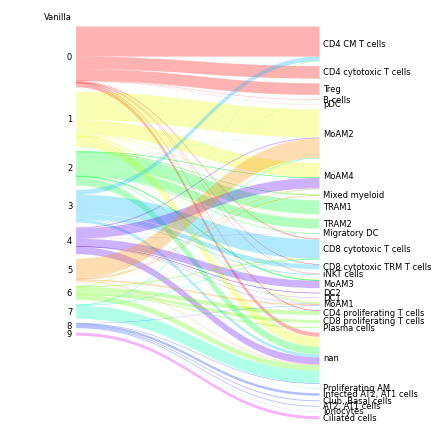

In [39]:
sankey.sankey(sc96.obs.leiden, celltype[sc96.obs_names], title_left="Vanilla");

Vanilla pipeline did not distinguish between infected and uninfected TRAMs.

Cluster **0** had 3 subsets of CD4 T cells. 

Cluster **6** is proliferating T cells

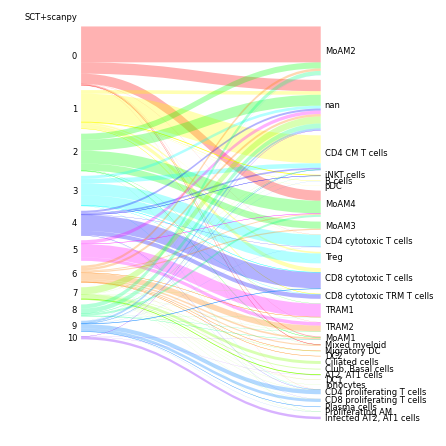

In [40]:
sankey.sankey(sc96_sct.obs.leiden, celltype[sc96_sct.obs_names], title_left="SCT+scanpy");

SCT+scanpy can partially distinguish TRAM1 vs TRAM2 (clusters **5** and **6**)

CD4 CM T cells is a separate cluster too, cluster **1**, not mixed with CD4 cytotoxic cells and Tregs

Infected AT2, AT1 cells were also a separate cluster **10**

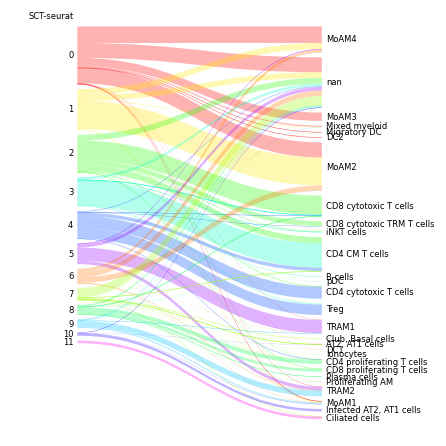

In [41]:
sankey.sankey(sc96_seurat.seurat_clusters, celltype[sc96_seurat.index], title_left="SCT-seurat");

SCT-seurat can also distinguish TRAM1 and TRAM2 (clusters 5 & 9)

Ciliated cells are picked up separately, cluster 11

Infected AT2, AT1 cells are separate, cluster 10

CD4 CM T cells are apart from Treg and CD4 cytotoxic T cells, cluster 3

## How those clusterings map on top of each other?

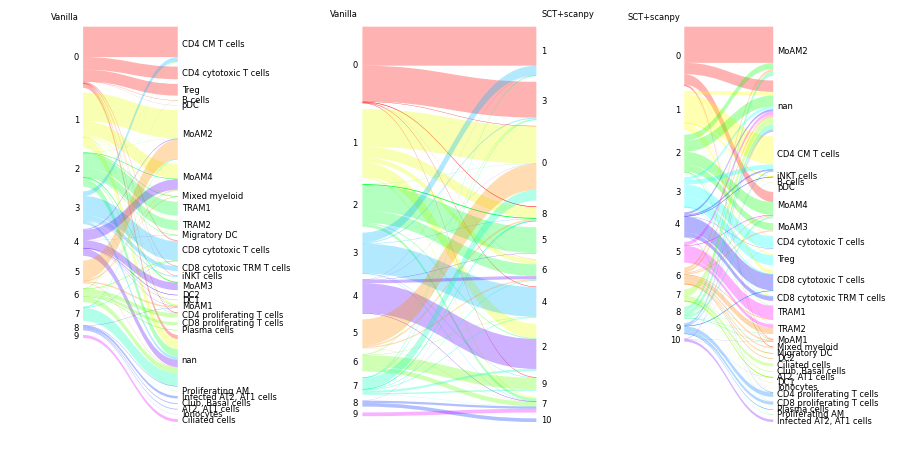

In [42]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 8), gridspec_kw={
    "width_ratios": [1, 1, 1],
    "wspace": 0
})
sankey.sankey(sc96.obs.leiden, celltype[sc96.obs_names], title_left="Vanilla", ax=axes[0]);
sankey.sankey(sc96.obs.leiden, sc96_sct.obs.leiden[sc96.obs_names], title_left="Vanilla", title_right="SCT+scanpy", ax=axes[1]);
sankey.sankey(sc96_sct.obs.leiden, celltype[sc96_sct.obs_names], title_left="SCT+scanpy", ax=axes[2]);

In the center is the mapping between Vanilla clustering and SCT+scanpy clustering. The thickness of the connecting stripes represents the amount of cells labelled as left label in Vanilla pipeline and as right label in SCT+scanpy.

On the left is cell type mapping for Vanilla, and on the right is cell type mapping for SCT+scanpy, to ease the interpretation.

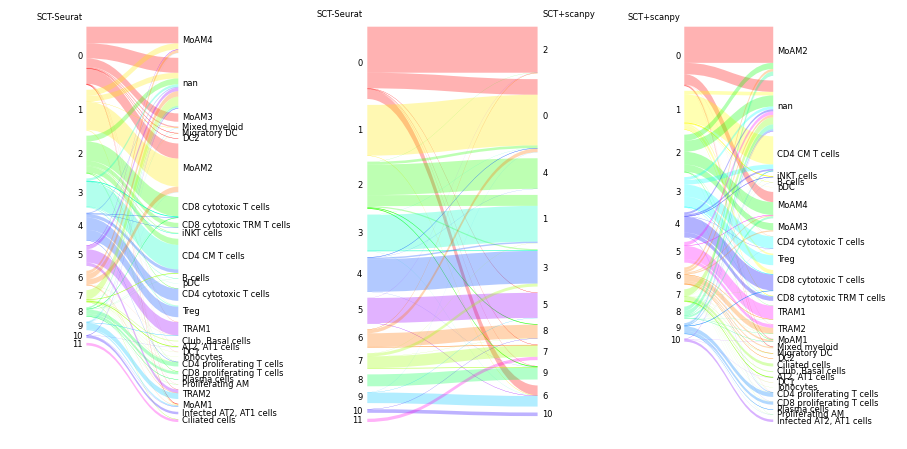

In [43]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 8), gridspec_kw={
    "width_ratios": [1, 1, 1],
    "wspace": 0
})
sankey.sankey(sc96_seurat.seurat_clusters, celltype[sc96_seurat.index], title_left="SCT-Seurat", ax=axes[0]);
sankey.sankey(sc96_seurat.seurat_clusters, sc96_sct.obs.leiden[sc96_seurat.index], title_left="SCT-Seurat", title_right="SCT+scanpy", ax=axes[1]);
sankey.sankey(sc96_sct.obs.leiden, celltype[sc96_sct.obs_names], title_left="SCT+scanpy", ax=axes[2]);

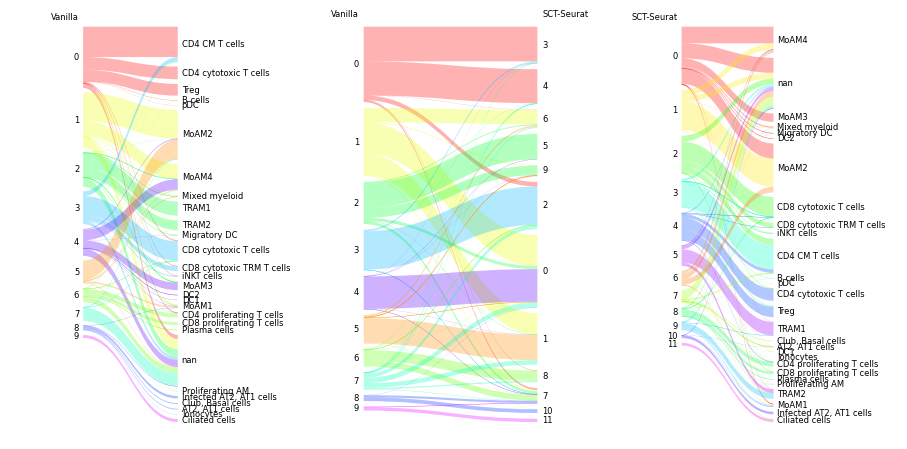

In [44]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 8), gridspec_kw={
    "width_ratios": [1, 1, 1],
    "wspace": 0
})
sankey.sankey(sc96.obs.leiden, celltype[sc96.obs_names], title_left="Vanilla", ax=axes[0]);
sankey.sankey(sc96.obs.leiden, sc96_seurat.seurat_clusters[sc96.obs_names], title_left="Vanilla", title_right="SCT-Seurat", ax=axes[1]);
sankey.sankey(sc96_seurat.seurat_clusters, celltype[sc96_seurat.index], title_left="SCT-Seurat", ax=axes[2]);

Overall, there is a considerable agreement between SCT+scanpy and SCT-Seurat, with less agreement between them and Vanilla.

SCT+scanpy and SCT-Seurat divide MoAM and T cell subclusters differently, which is expected as there is a gradient.
Same goes for TRAM1 and TRAM2 clusters.

SCT+scanpy fails to separate Ciliated cells from low-quality cells (cluster 7), while both SCT-Seurat and Vanilla pipeline are able to do that.

## Why were Ciliated cells not picked up?

### 1. Let's confirm that SCT loading in SCT+scanpy works correctly

Load PCA values directly from SCT-Seurat

In [45]:
sc96_pca = pd.read_csv("sc96-pca.csv", index_col=0)

For some reason every other PC is multiplied by -1 in Seurat relative to scanpy

In [46]:
pca_multipliers = [-1, 1] * 25

Compare to PCA matrices

In [49]:
(sc96_pca.mul(pca_multipliers).to_numpy().astype(np.float32) - sc96_sct.obsm["X_pca"]).mean()

9.936003e-10

Ok, mean difference is very low, but maybe it is enough or multipliers are enough for scanpy to cluster cells differently?

### 2. Let's cluster with PCA from SCT-Seurat

In [52]:
sc96_sct.obsm["X_pca"] = sc96_pca.to_numpy().astype(np.float32)

In [53]:
sc.pp.neighbors(sc96_sct, n_pcs=15)

In [54]:
sc.tl.leiden(sc96_sct, resolution=0.5)

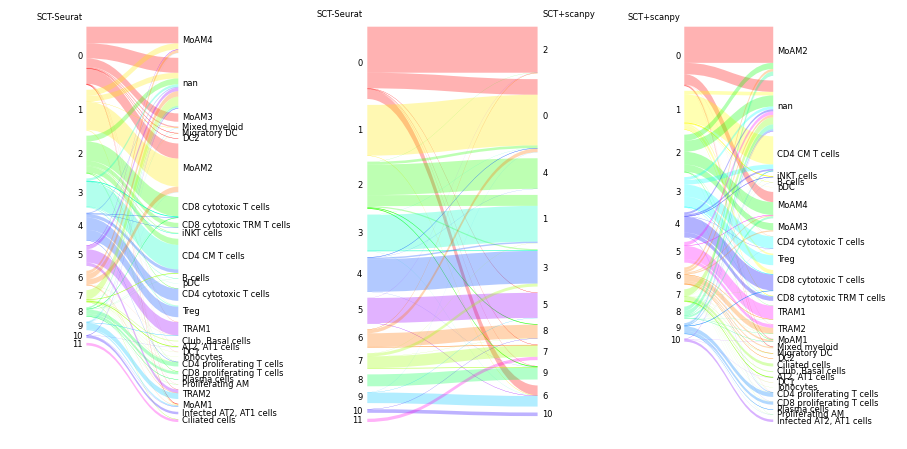

In [55]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 8), gridspec_kw={
    "width_ratios": [1, 1, 1],
    "wspace": 0
})
sankey.sankey(sc96_seurat.seurat_clusters, celltype[sc96_seurat.index], title_left="SCT-Seurat", ax=axes[0]);
sankey.sankey(sc96_seurat.seurat_clusters, sc96_sct.obs.leiden[sc96_seurat.index], title_left="SCT-Seurat", title_right="SCT+scanpy", ax=axes[1]);
sankey.sankey(sc96_sct.obs.leiden, celltype[sc96_sct.obs_names], title_left="SCT+scanpy", ax=axes[2]);

No, this did not change things.

### 3. Let's check marker genes for Ciliated cells cluster among HVG

HVG are the same for SCT+scanpy and for SCT-Seurat pipelines, coming from SCT algorithm, but different in Vanilla.

In [56]:
sc96_hvg = sc96.var_names[sc96.var.highly_variable]

In [57]:
sc96_sct_hvg = sc96_sct.var_names[sc96_sct.var.highly_variable]

In [58]:
sc96_hvg[~sc96_hvg.isin(sc96_sct_hvg)].size

884

Out of 3k HVGs, 844 are unique to Vanilla and SCT+scanpy, and the remaining 2100+ are common.

**Hypothesis**

SCT+scanpy pipeline does not pick up Ciliated cells as individual cluster, because it has fewer markers genes for that cluster among highly variable genes.

Let's test this by loading marker genes from SCT-Seurat pipeline and checking how many markers for Ciliated cells (cluster 11) are there in the Vanilla HVG list and in the SCT HVG list.

In [59]:
markers = pd.read_csv("sc96-markers.csv", index_col=0)

Pick specific markers for cluster 11: average log-fold change > 1 and expressed in 10% of other cells or less

In [60]:
ciliated_markers = markers.sort_values(
    "avg_log2FC", 
    ascending=False
).gene[(markers.cluster == 11) & (markers.avg_log2FC > 1) & (markers["pct.2"] < 0.1)]

In [61]:
ciliated_markers.size

210

In [62]:
ciliated_markers.isin(sc96_hvg).sum()

102

In [63]:
ciliated_markers.isin(sc96_sct_hvg).sum()

173

This hypothesis does not hold true by the total number of genes.

However, maybe Vanilla HVG have more important genes? Let's look at a cumulative distribution of intersection size for ordered markers.

In [64]:
x = list(range(ciliated_markers.size))[1:]

In [65]:
sc96_y = []
sc96_sct_y = []
for i in x:
    genes = ciliated_markers[:i]
    sc96_y.append(genes.isin(sc96_hvg).sum())
    sc96_sct_y.append(genes.isin(sc96_sct_hvg).sum())

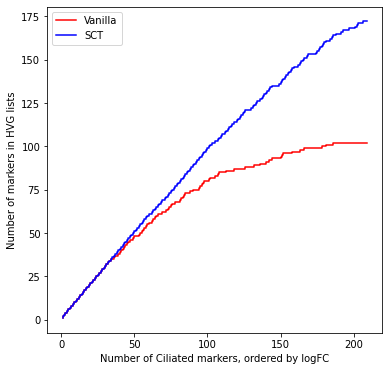

In [66]:
fig, ax = plt.subplots()
ax.step(x, sc96_y, c="r", label="Vanilla")
ax.step(x, sc96_sct_y, c="b", label="SCT")
ax.set_xlabel("Number of Ciliated markers, ordered by logFC")
ax.set_ylabel("Number of markers in HVG lists")
ax.legend()

For markers ordered by average logFC in a decreasing order, SCT HVG list always has equal or more markers than Vanilla HVG list. The hypothesis that SCT+scanpy pipeline does not pick up Ciliated cells as individual cluster, because it has fewer markers genes for that cluster among highly variable genes is refuted.

The question remains: Vanilla pipeline separates Ciliated cells into a distinct cluster; SCT-Seurat also separates Ciliated cells into a distinct cluster; why does SCT+scanpy not do it, while operating on same PCA matrix as SCT-Seurat, and having more Ciliated cell markers among it HVG list?

### 4. Maybe scanpy just has a different resolution while clustering?

In this case, 0.5 in SCT-Seurat could be 0.6 in scanpy, and the clustering would become equivalent

First, let's bring back PCA to SCT+scanpy

In [67]:
sc.tl.pca(sc96_sct, svd_solver="arpack", use_highly_variable=True)

In [70]:
sc.pp.neighbors(sc96_sct, n_pcs=15)

In [71]:
sc.tl.leiden(sc96_sct, resolution=0.5)

Now, let's increase resolution until we have 1 more cluster and see what would that split be

In [72]:
n_clusters = sc96_sct.obs.leiden.unique().size
target = n_clusters + 1
resolution_step = 0.01
resolution = 0.5
while n_clusters < target:
    resolution += resolution_step
    sc.tl.leiden(sc96_sct, resolution=resolution)
    n_clusters = sc96_sct.obs.leiden.unique().size
print(f"1 more cluster appeared at resolution {resolution}")

1 more cluster appeared at resolution 0.51


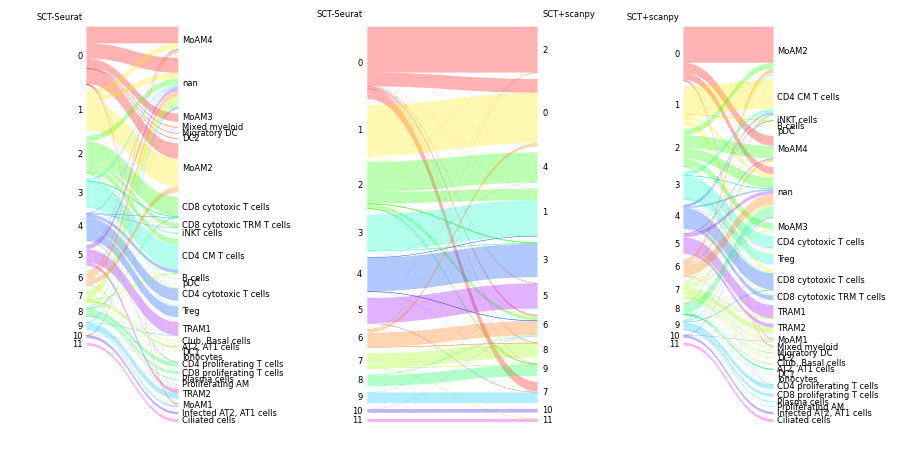

In [73]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 8), gridspec_kw={
    "width_ratios": [1, 1, 1],
    "wspace": 0
})
sankey.sankey(sc96_seurat.seurat_clusters, celltype[sc96_seurat.index], title_left="SCT-Seurat", ax=axes[0]);
sankey.sankey(sc96_seurat.seurat_clusters, sc96_sct.obs.leiden[sc96_seurat.index], title_left="SCT-Seurat", title_right="SCT+scanpy", ax=axes[1]);
sankey.sankey(sc96_sct.obs.leiden, celltype[sc96_sct.obs_names], title_left="SCT+scanpy", ax=axes[2]);

This split did indeed separate Ciliated cells (cluster 11) from cluster 8 in SCT+scanpy.

This is promising. Let's move to the second test case

# Dataset SC167

Same approach, except that we haven't annotated this dataset in Grant et al., 2020, so I will do my own annotation based on SCT-Seurat.

In [74]:
annotations = {
    0: "MoAM",
    1: "Plasma cells 1",
    2: "TRAM",
    3: "Plasma cells 2",
    4: "Plasma cells 3",
    5: "Plasma cells 4",
    6: "T cells",
    7: "Plasma cells 5",
    8: "B cells",
    9: "DC1",
    10: "Plasma cells 6",
    11: "Plasma cells 7",
    12: "Migratory DC"
}

### Vanilla

In [75]:
sc167 = sc.read_10x_mtx(
    "../../data/02sctransform-test/SC167/",
    var_names="gene_symbols",
    make_unique=False
)
sc167.var_names_make_unique(join=".")
sc167.var_names = rename_genes(sc167.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [76]:
sc.pp.filter_cells(sc167, min_genes=200)
sc.pp.filter_genes(sc167, min_cells=5)
sc.pp.normalize_total(sc167, target_sum=1e4)
sc.pp.log1p(sc167)
sc167.raw = sc167
sc.pp.highly_variable_genes(sc167, n_top_genes=3000)
sc.pp.scale(sc167)
sc.tl.pca(sc167, svd_solver="arpack", use_highly_variable=True)

In [77]:
sc.pp.neighbors(sc167, n_pcs=15)

In [78]:
sc.tl.leiden(sc167, resolution=0.5)

In [79]:
sc.tl.umap(sc167)

... storing 'feature_types' as categorical


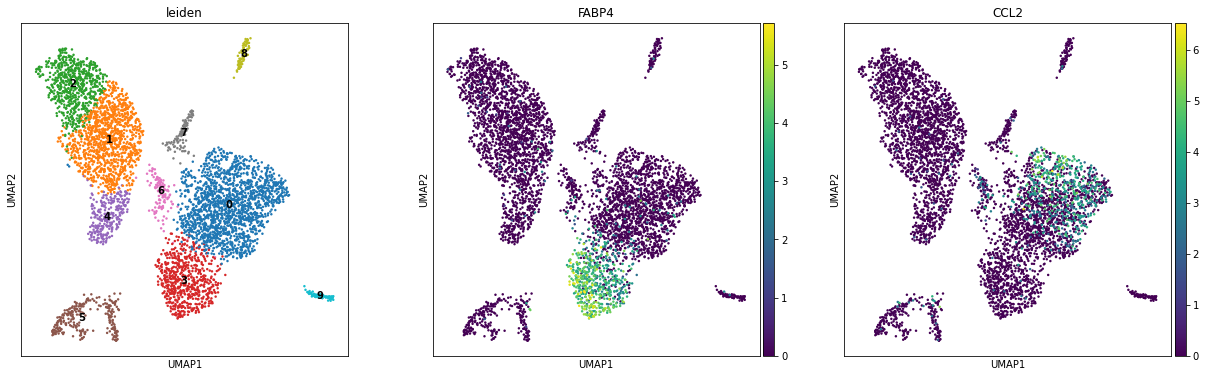

In [80]:
ax = sc.pl.umap(sc167, color=['leiden', 'FABP4', 'CCL2'], show=False, legend_loc="on data")
ax[0].figure.savefig("sc167-vanilla.pdf")

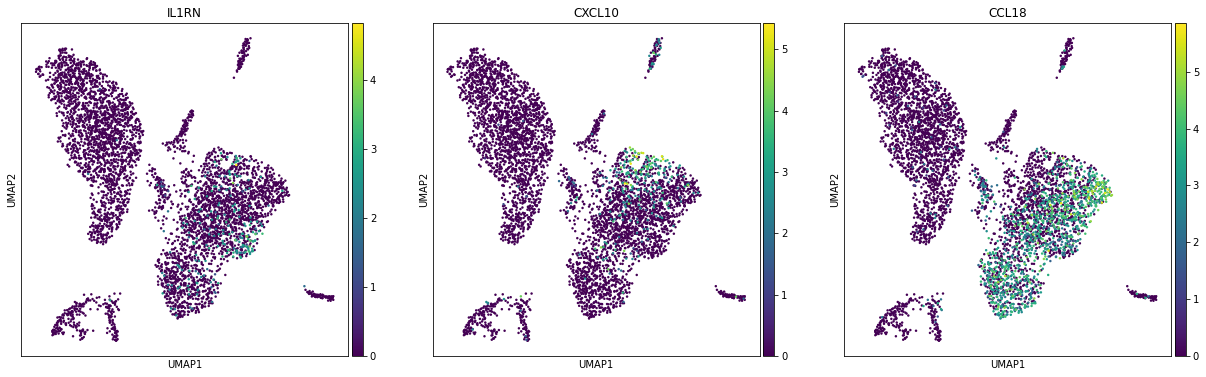

In [81]:
ax = sc.pl.umap(sc167, color=['IL1RN', 'CXCL10', 'CCL18'], show=False)
ax[0].figure.savefig("sc167-vanilla2.pdf")

### SCT+scanpy

In [82]:
sc167_sct = sc.read_10x_mtx(
    "../../data/02sctransform-test/SC167/",
    var_names="gene_symbols",
    make_unique=False
)
sc167_sct.var_names_make_unique(join=".")
sc167_sct.var_names = rename_genes(sc167_sct.var_names)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [83]:
sc.pp.filter_cells(sc167_sct, min_genes=200)
sc.pp.filter_genes(sc167_sct, min_cells=5)

In [84]:
counts = scipy.io.mmread("../../data/02sctransform-test/SC167-sct/log-counts.mtx")

In [85]:
sc167_sct.X = counts.tocsc().T
sc167_sct.raw = sc167_sct

In [86]:
scaled = pd.read_csv("../../data/02sctransform-test/SC167-sct/hvg-scaled.tsv", sep="\t")

In [87]:
scaled.index = scaled.index.str.replace("SARS-CoV-2i-", "SARS-CoV-2i_").str.replace("GRCh38------", "GRCh38______")
scaled.index = rename_genes(scaled.index)

In [88]:
missing_genes = sc167_sct.var_names[~sc167_sct.var_names.isin(scaled.index)]

In [89]:
zeros = np.zeros((sc167_sct.n_obs, missing_genes.size))

In [90]:
zeros = pd.DataFrame(zeros, index=sc167_sct.obs_names, columns=missing_genes)

In [91]:
sc167_sct.X = pd.concat([scaled.T, zeros], axis=1).loc[:, sc167_sct.var_names]

In [92]:
sc167_sct.var["highly_variable"] = False
sc167_sct.var.loc[sc167_sct.var_names.isin(scaled.index), "highly_variable"] = True

In [93]:
sc.tl.pca(sc167_sct, svd_solver="arpack", use_highly_variable=True)

In [94]:
sc.pp.neighbors(sc167_sct, n_pcs=15)

In [95]:
sc.tl.leiden(sc167_sct, resolution=0.61)

In [96]:
sc167_sct.obs.leiden.unique().size

14

In [97]:
sc.tl.umap(sc167_sct)

... storing 'feature_types' as categorical


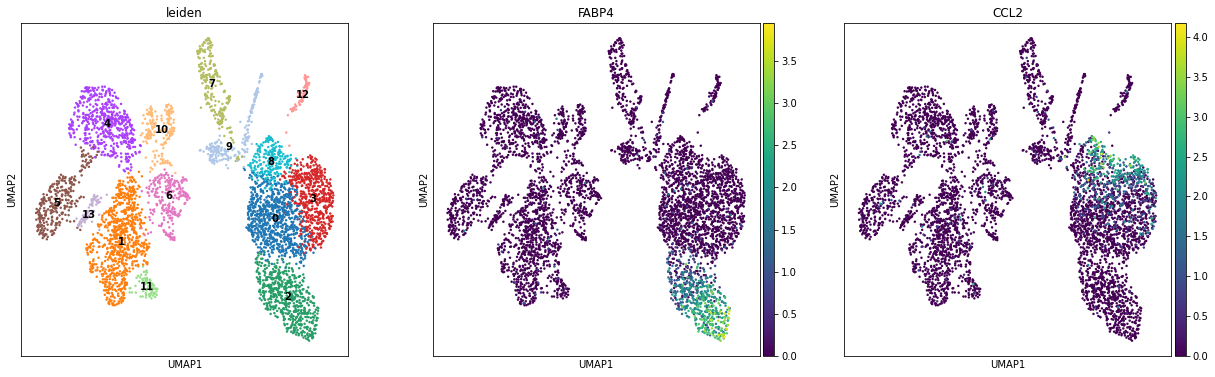

In [98]:
ax = sc.pl.umap(sc167_sct, color=['leiden', 'FABP4', 'CCL2'], show=False, legend_loc="on data")
ax[0].figure.savefig("sc167-sct.pdf")

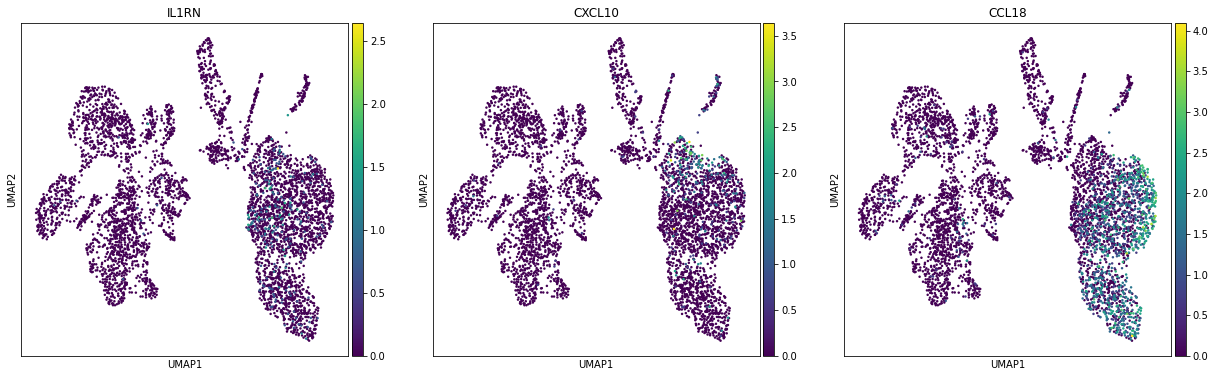

In [99]:
ax = sc.pl.umap(sc167_sct, color=['IL1RN', 'CXCL10', 'CCL18'], show=False)
ax[0].figure.savefig("sc167-sct2.pdf")

### SCT-Seurat

In [100]:
sc167_seurat = pd.read_csv("../../data/02sctransform-test/SC167-metadata.csv", index_col=0)

In [101]:
sc167_seurat["cluster"] = sc167_seurat.seurat_clusters.map(annotations)

In [102]:
sc167_seurat.index = sc167_seurat.index.str.replace("SC167_", "")

### Mapping to annotated SCT-Seurat

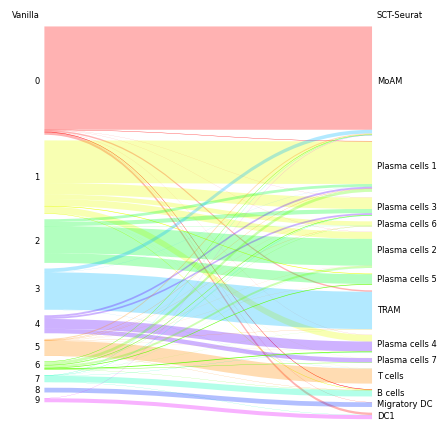

In [103]:
sankey.sankey(sc167.obs.leiden, sc167_seurat.cluster[sc167.obs_names], title_left="Vanilla", title_right="SCT-Seurat");

Similar subtypes of Plasma cells got intermixed here, but the rest of the cell types are the same.

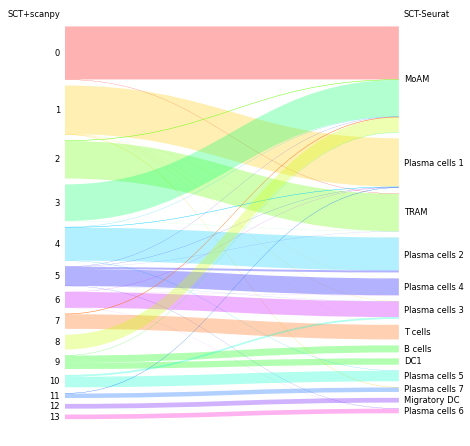

In [104]:
sankey.sankey(sc167_sct.obs.leiden, sc167_seurat.cluster[sc167_sct.obs_names], title_left="SCT+scanpy", title_right="SCT-Seurat");

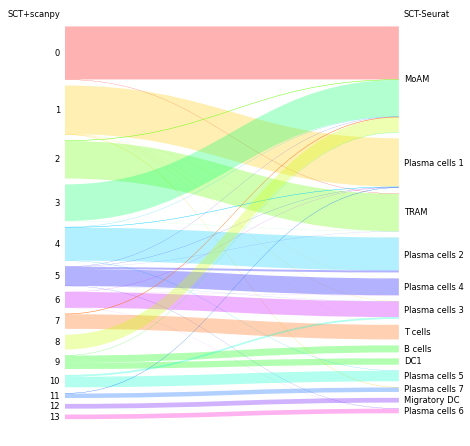

In [105]:
sankey.sankey(sc167_sct.obs.leiden, sc167_seurat.cluster[sc167_sct.obs_names], title_left="SCT+scanpy", title_right="SCT-Seurat");

SCT+scanpy identified one additional subcluster of MoAMs.

Plasma cells were groups very much like in SCT+scanpy.

SCT+scanpy failed to distinguish between B cells and DC1, while Vanilla and SCT-Seurat do not

### Mapping between Vanilla and SCT+scanpy

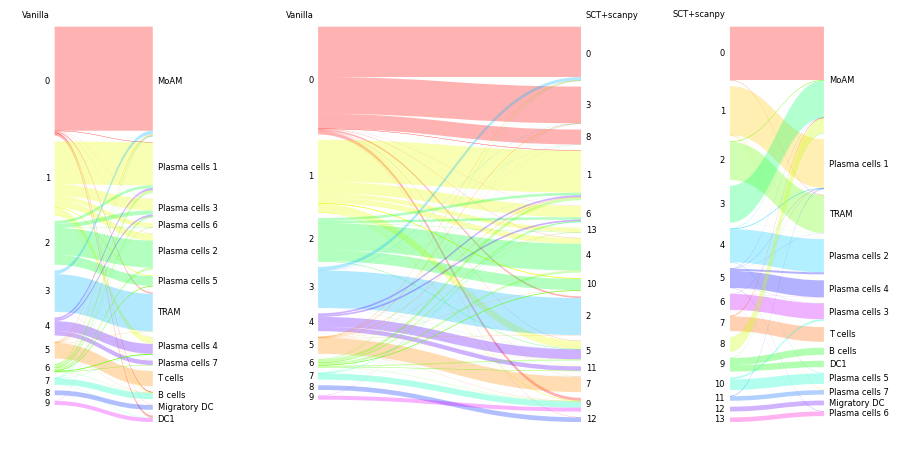

In [106]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 8), gridspec_kw={
    "width_ratios": [1, 2, 1],
    "wspace": 0
})
sankey.sankey(sc167.obs.leiden, sc167_seurat.cluster[sc167.obs_names], title_left="Vanilla", ax=axes[0]);
sankey.sankey(sc167.obs.leiden, sc167_sct.obs.leiden[sc167.obs_names], title_left="Vanilla", title_right="SCT+scanpy", ax=axes[1]);
sankey.sankey(sc167_sct.obs.leiden, sc167_seurat.cluster[sc167_sct.obs_names], title_left="SCT+scanpy", ax=axes[2]);


Most of the splits reflect the different subclustering of Plasma cells

Previously observed split in MoAM in SCT+scanpy is present here too, as well as the merge of B cells and DC1 clusters

## Why B cells and DC1 cells were merged in SCT+scanpy?

### 1. Let's confirm that SCT loading in SCT+scanpy works correctly

Load PCA values directly from SCT-Seurat

In [107]:
sc167_pca = pd.read_csv("sc167-pca.csv", index_col=0)

Compare to PCA matrices

In [108]:
(sc167_pca.mul(pca_multipliers).to_numpy().astype(np.float32) - sc167_sct.obsm["X_pca"]).mean()

-1.0282571e-09

Ok, mean difference is very low, but maybe it is enough or multipliers are enough for scanpy to cluster cells differently?

### 2. Let's cluster with PCA from SCT-Seurat

In [109]:
sc167_sct.obsm["X_pca"] = sc167_pca.to_numpy().astype(np.float32)

In [110]:
sc.pp.neighbors(sc167_sct, n_pcs=15)

In [111]:
sc.tl.leiden(sc167_sct, resolution=0.5)

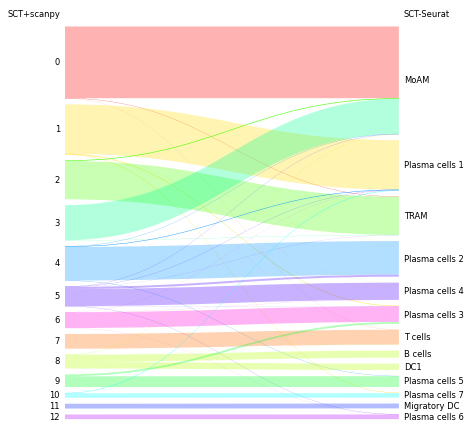

In [112]:
sankey.sankey(sc167_sct.obs.leiden, sc167_seurat.cluster[sc167_sct.obs_names], title_left="SCT+scanpy", title_right="SCT-Seurat");

No, this did not change things.

### 3. Let's check marker genes for B cells and DC1 clusters among HVG

HVG are the same for SCT+scanpy and for SCT-Seurat pipelines, coming from SCT algorithm, but different in Vanilla.

In [113]:
sc167_hvg = sc167.var_names[sc167.var.highly_variable]

In [114]:
sc167_sct_hvg = sc167_sct.var_names[sc167_sct.var.highly_variable]

In [115]:
sc167_hvg[~sc167_hvg.isin(sc167_sct_hvg)].size

933

Out of 3k HVGs, 933 are unique to Vanilla and SCT+scanpy, and the remaining 2000+ are common.

**Hypothesis**

SCT+scanpy pipeline does not pick up B cells or DC1 as individual cluster, because it has fewer markers genes for these clusters among highly variable genes.

Let's test this by loading marker genes from SCT-Seurat pipeline and checking how many markers for B cells and DC1 (clusters 8 & 9) are there in the Vanilla HVG list and in the SCT HVG list.

In [116]:
markers = pd.read_csv("sc167-markers.csv", index_col=0)

Pick specific markers for B cells: average log-fold change > 0.5 and expressed in 10% of other cells or less

In [119]:
b_cells_markers = markers.sort_values(
    "avg_log2FC", 
    ascending=False
).gene[(markers.cluster == 8) & (markers.avg_log2FC > 0.5) & (markers["pct.2"] < 0.1)]

In [120]:
b_cells_markers.size

6

In [121]:
b_cells_markers.isin(sc167_hvg).sum()

4

In [122]:
b_cells_markers.isin(sc167_sct_hvg).sum()

6

Pick specific markers for DC1 cells: average log-fold change > 0.5 and expressed in 10% of other cells or less

In [124]:
dc1_cells_markers = markers.sort_values(
    "avg_log2FC", 
    ascending=False
).gene[(markers.cluster == 9) & (markers.avg_log2FC > 0.5) & (markers["pct.2"] < 0.1)]

In [125]:
dc1_cells_markers.size

14

In [126]:
dc1_cells_markers.isin(sc167_hvg).sum()

14

In [127]:
dc1_cells_markers.isin(sc167_sct_hvg).sum()

14

Yes, both clusters have just a few markers, however they are quite specific

In [135]:
markers.loc[markers.gene.isin(list(b_cells_markers) + list(dc1_cells_markers)), :]

p_val  avg_log2FC  pct.1  pct.2      p_val_adj  cluster  \
MS4A1    1.057926e-114    1.206130  0.573  0.004  1.502255e-110        8   
SMIM14    9.936642e-45    0.652643  0.427  0.053   1.411003e-40        8   
ID3       2.427429e-23    0.611097  0.391  0.059   3.446949e-19        8   
STK17A    2.529988e-21    0.599066  0.445  0.091   3.592584e-17        8   
CD79A     3.653033e-13    0.532845  0.427  0.099   5.187306e-09        8   
LTB       9.968308e-12    0.587962  0.291  0.023   1.415500e-07        8   
NAAA      2.616481e-93    0.994793  0.535  0.047   3.715403e-89        9   
S100B     1.978404e-84    2.047752  0.606  0.008   2.809333e-80        9   
CPVL      4.535898e-80    1.161651  0.596  0.059   6.440975e-76        9   
C1orf54   3.533884e-74    0.996241  0.475  0.025   5.018116e-70        9   
NAPSA     6.326102e-74    0.854758  0.434  0.014   8.983065e-70        9   
FGL2      5.120973e-64    0.944239  0.556  0.054   7.271782e-60        9   
IRF8      8.174036e-55    0.752815  0.414  0.034   1.160713e-50        9   
CCND1     8.422763e-51    0.536099  0.273  0.003   1.196032e-46        9   
CPNE3     3.746492e-50    0.768249  0.434  0.051   5.320019e-46        9   
RAB32     9.777209e-48    0.731674  0.414  0.048   1.388364e-43        9   
LGALS2    1.049854e-44    0.625646  0.293  0.001   1.490793e-40        9   
CLEC9A    6.316644e-27    0.519495  0.283  0.001   8.969634e-23        9   
LTB1      1.424892e-10    0.606470  0.232  0.025   2.023347e-06        9   
CST7      6.408245e-10    0.543556  0.374  0.026   9.099708e-06        9   
CST71     5.407421e-21    0.950962  0.446  0.027   7.678538e-17       12   

            gene  
MS4A1      MS4A1  
SMIM14    SMIM14  
ID3          ID3  
STK17A    STK17A  
CD79A      CD79A  
LTB          LTB  
NAAA        NAAA  
S100B      S100B  
CPVL        CPVL  
C1orf54  C1orf54  
NAPSA      NAPSA  
FGL2        FGL2  
IRF8        IRF8  
CCND1      CCND1  
CPNE3      CPNE3  
RAB32      RAB32  
LGALS2    LGALS2  
CLEC9A    CLEC9A  
LTB1         LTB  
CST7        CST7  
CST71       CST7

No, absence of markers from HVG is not the reason. SCT has as many

The question remains: Vanilla pipeline separates B cells and DC1; SCT-Seurat also separates B cells from DC1 ; why does SCT+scanpy not do it, while operating on same PCA matrix as SCT-Seurat, and having same markers among its HVG list?

### 4. Maybe scanpy just has a different resolution while clustering?

In this case, 0.5 in SCT-Seurat could be 0.6 in scanpy, and the clustering would become equivalent

First, let's bring back PCA to SCT+scanpy

In [128]:
sc.tl.pca(sc167_sct, svd_solver="arpack", use_highly_variable=True)

In [129]:
sc.pp.neighbors(sc167_sct, n_pcs=15)

In [130]:
sc.tl.leiden(sc167_sct, resolution=0.5)

Now, let's increase resolution until we have 1 more cluster and see what would that split be

In [131]:
n_clusters = sc167_sct.obs.leiden.unique().size
target = n_clusters + 1
resolution_step = 0.01
resolution = 0.5
while n_clusters < target:
    resolution += resolution_step
    sc.tl.leiden(sc167_sct, resolution=resolution)
    n_clusters = sc167_sct.obs.leiden.unique().size
print(f"1 more cluster appeared at resolution {resolution}")

1 more cluster appeared at resolution 0.6100000000000001


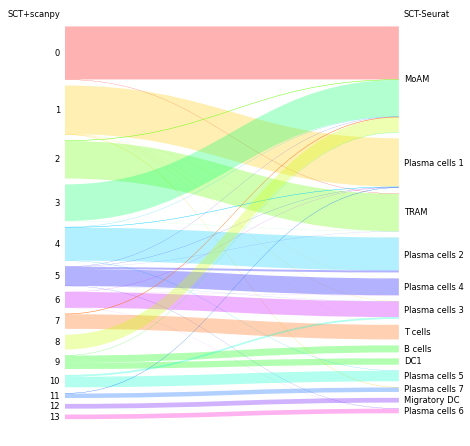

In [132]:
sankey.sankey(sc167_sct.obs.leiden, sc167_seurat.cluster[sc167_sct.obs_names], title_left="SCT+scanpy", title_right="SCT-Seurat");

This split identified one more subset of MoAM cluster, but not B cells vs DC1.

Let's try one more time

In [133]:
n_clusters = sc167_sct.obs.leiden.unique().size
target = n_clusters + 1
resolution_step = 0.01
resolution = 0.5
while n_clusters < target:
    resolution += resolution_step
    sc.tl.leiden(sc167_sct, resolution=resolution)
    n_clusters = sc167_sct.obs.leiden.unique().size
print(f"1 more cluster appeared at resolution {resolution}")

1 more cluster appeared at resolution 0.6700000000000002


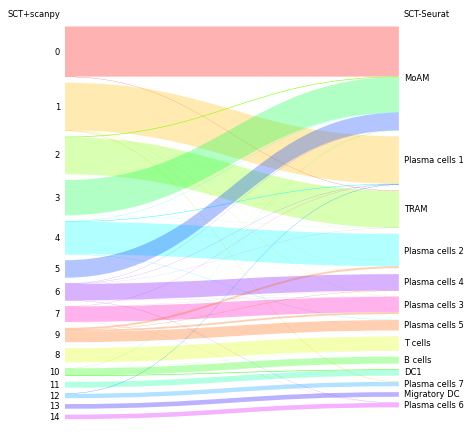

In [134]:
sankey.sankey(sc167_sct.obs.leiden, sc167_seurat.cluster[sc167_sct.obs_names], title_left="SCT+scanpy", title_right="SCT-Seurat");

This did the job, but it is not very encouraging.

Why MoAM split before B cells and DC1?

Let's look at markers genes on this clustering

In [136]:
def get_markers(anndata, groupby):
    def calc_pct_1(x):
        cells = anndata.obs[groupby] == x.cluster
        gene = anndata.var_names == x.gene
        return (anndata.X[cells, gene] > 0).sum() / cells.sum()

    def calc_pct_2(x):
        cells = anndata.obs[groupby] != x.cluster
        gene = anndata.var_names == x.gene
        return (anndata.X[cells, gene] > 0).sum() / cells.sum()

    markers = pd.concat([
        pd.DataFrame(anndata.uns["rank_genes_groups"]["names"]).melt(),
        pd.DataFrame(anndata.uns["rank_genes_groups"]["pvals_adj"]).melt(),
        pd.DataFrame(anndata.uns["rank_genes_groups"]["logfoldchanges"]).melt()
    ], axis=1)
    markers.columns = ("cluster", "gene", "cluster2", "p_val_adj", "cluster3", "avg_logFC")
    markers = markers.loc[:, ["cluster", "gene", "avg_logFC", "p_val_adj"]]
    markers = markers.loc[markers.avg_logFC > 0.5, ]
    markers = markers.loc[markers.p_val_adj < 0.05, ]
    markers["pct.1"] = markers.apply(calc_pct_1, axis=1)
    markers["pct.2"] = markers.apply(calc_pct_2, axis=1)
    markers["p_val"] = markers.p_val_adj
    markers = markers.loc[:, ["p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"]]
    return markers

In [137]:
sc.tl.rank_genes_groups(sc167_sct, "leiden", method="wilcoxon", n_genes=0)

In [138]:
markers = get_markers(sc167_sct, "leiden")

In [141]:
markers.cluster = markers.cluster.astype(int)

In [145]:
markers = markers.sort_values(
    ["cluster", "avg_logFC"], 
    ascending=[True, False]
)
markers.loc[markers.cluster.isin([5, 10, 11])].cluster.value_counts()

5     198
10    124
11    107
Name: cluster, dtype: int64

Well, cluster 5 has more markers, that could be the reason

In [146]:
markers = markers.sort_values(
    ["cluster", "avg_logFC"], 
    ascending=[True, False]
)
markers.loc[markers.cluster.isin([5, 10, 11])].groupby("cluster").head(20)

p_val  avg_logFC     pct.1     pct.2     p_val_adj  cluster  \
66201   1.661801e-02   7.395290  0.125899  0.001074  1.661801e-02        5   
66026   3.155542e-40   3.847143  0.564748  0.093878  3.155542e-40        5   
66049   5.856676e-15   3.827819  0.338129  0.041246  5.856676e-15        5   
66102   9.717881e-07   3.808867  0.223022  0.020408  9.717881e-07        5   
66179   6.330206e-03   3.707068  0.151079  0.012889  6.330206e-03        5   
66010   2.283051e-79   3.601500  0.805755  0.209023  2.283051e-79        5   
66190   1.116496e-02   3.097821  0.147482  0.018475  1.116496e-02        5   
66028   1.996010e-32   3.053364  0.532374  0.113426  1.996010e-32        5   
66014   1.115605e-51   3.013258  0.694245  0.204082  1.115605e-51        5   
66024   1.178164e-41   2.941236  0.633094  0.179807  1.178164e-41        5   
66134   2.298131e-04   2.939227  0.194245  0.030934  2.298131e-04        5   
66153   1.808847e-03   2.675139  0.179856  0.034372  1.808847e-03        5   
66068   9.728405e-11   2.663464  0.320144  0.064447  9.728405e-11        5   
66089   2.890816e-08   2.586926  0.280576  0.058432  2.890816e-08        5   
66146   8.290673e-04   2.487754  0.197842  0.045542  8.290673e-04        5   
66138   3.614406e-04   2.468994  0.215827  0.059076  3.614406e-04        5   
66101   9.356168e-07   2.434278  0.255396  0.054565  9.356168e-07        5   
66131   1.315903e-04   2.433481  0.215827  0.050483  1.315903e-04        5   
66023   7.281698e-42   2.423531  0.672662  0.236520  7.281698e-42        5   
66037   1.270445e-20   2.349412  0.467626  0.137057  1.270445e-20        5   
132026  7.643876e-20   8.228864  0.528926  0.003741  7.643876e-20       10   
132137  2.146158e-02   4.784240  0.198347  0.009144  2.146158e-02       10   
132099  1.015109e-04   4.289466  0.280992  0.023067  1.015109e-04       10   
132144  3.960329e-02   3.648440  0.000000  0.000000  3.960329e-02       10   
132138  2.342216e-02   3.601977  0.206612  0.018288  2.342216e-02       10   
132071  9.217605e-09   3.457084  0.396694  0.052993  9.217605e-09       10   
132082  7.748038e-07   3.087167  0.363636  0.059227  7.748038e-07       10   
132114  1.826417e-03   2.953870  0.264463  0.039692  1.826417e-03       10   
132073  1.867252e-08   2.940447  0.413223  0.090815  1.867252e-08       10   
132084  9.697028e-07   2.588549  0.396694  0.099127  9.697028e-07       10   
132121  4.149206e-03   2.278902  0.000000  0.000000  4.149206e-03       10   
132107  5.136120e-04   2.219871  0.000000  0.000000  5.136120e-04       10   
132060  2.238772e-10   2.096195  0.537190  0.200540  2.238772e-10       10   
132148  4.932449e-02   2.017734  0.000000  0.000000  4.932449e-02       10   
132102  1.413533e-04   2.008869  0.371901  0.140898  1.413533e-04       10   
132110  1.406557e-03   1.975934  0.330579  0.121779  1.406557e-03       10   
132069  3.415345e-09   1.860563  0.545455  0.236700  3.415345e-09       10   
132087  1.129123e-06   1.859563  0.479339  0.219451  1.129123e-06       10   
132101  1.330478e-04   1.788086  0.396694  0.164796  1.330478e-04       10   
132132  1.810528e-02   1.720005  0.000000  0.000000  1.810528e-02       10   
145284  9.051292e-05   9.452400  0.304348  0.000620  9.051292e-05       11   
145277  1.677958e-05   8.620336  0.326087  0.001239  1.677958e-05       11   
145234  7.440330e-22   7.913780  0.630435  0.008056  7.440330e-22       11   
145324  1.594010e-02   7.320104  0.228261  0.001653  1.594010e-02       11   
145290  2.445996e-04   7.112428  0.293478  0.003099  2.445996e-04       11   
145250  1.065496e-10   5.722796  0.456522  0.014666  1.065496e-10       11   
145245  1.361193e-12   5.214199  0.500000  0.025201  1.361193e-12       11   
145316  3.955406e-03   4.918052  0.260870  0.012394  3.955406e-03       11   
145333  4.117289e-02   4.815404  0.217391  0.007643  4.117289e-02       11   
145224  6.879414e-50   4.719691  0.989130  0.350961  6.879414e-50       11   
145239  5.917647e-17   4.629325  0.58

# Conclusions

1. PCA values confirm that SCT+scanpy and SCT-Seurat are almost identical with the exception of multiplying some PCs by -1. This is good and proves that loading SCT values into scanpy goes as planned.

2. Overall, SCT+scanpy has more agreement with SCT-Seurat than Vanilla strategy

3. SCT+scanpy and SCT-Seurat demonstrated increased resolution on SC96 than Vanilla.

3. SCT+scanpy failed to resolve Ciliated cells (in SC96) and DC1 (in SC167), while both Vanilla and SCT-Seurat did. This is unexpected and somewhat alarming.

3. Increasing resolution in leiden clustering resolved those population, as well as several others. **General recommendation** is to use higher resolution with SCT+scanpy and overcluster, then merge strategy.

### The remaining questions:

1. Why Vanilla scanpy could resolve those populations, despite operating on less marker HVGs?

2. What is the difference between kNN graph construction and clustering between Seurat and scanpy?

3. How to be sure we did not undercluster and miss some smaller cell populations?